<a href="https://colab.research.google.com/github/sherlock216/20251R0136COSE47101/blob/main/GMM_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Probabilistic Clustering is different from K-Means clustering. It assigns a probability to each data point indicating the likelihood of belonging to each cluster. GMM(Gaussian Mixture Model) is a common probabilistic clustering model.

It assumes a mixture of Gaussian distributions, and it has E-Step and M-Step.
E-Step: Calculate the probability that each data point belongs to each other, based on the current parameters.
M-Step: Update the parameters of each Gaussian distribution to maximize the likelihood of the data given the model.

# 1. Preparing the dataset for clustering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import glob
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
# 데이터 로드
# 경로에 있는 모든 github_profiles*.csv 파일을 찾음
file_path = '/content/drive/MyDrive/Colab Notebooks/COSE471/test/results2/github_profiles_total_v2.csv'

# 2. CSV 로드 + 컬럼 이름 공백 제거
df = pd.read_csv(file_path, index_col=False).fillna(0)
df.columns = df.columns.str.strip()  # ← 여기에서 컬럼 이름 공백 제거

print(f"총 {len(df)}개의 사용자 데이터 로드 완료")
print(f"컬럼 이름: {list(df.columns)}")

총 3799개의 사용자 데이터 로드 완료
컬럼 이름: ['user_ID', 'username', 'repo_count', 'Assembly', 'C', 'C++', 'C#', 'Dart', 'Go', 'Java', 'JavaScript', 'Kotlin', 'MATLAB', 'PHP', 'Python', 'Ruby', 'Rust', 'Scala', 'Swift', 'TypeScript']


In [4]:
print(len(df))

3799


In [5]:
# repo_count 기준으로 df 자체를 필터링
df = df[df.iloc[:, 2] >= 6].reset_index(drop=True)

# 프로그래밍 언어 데이터 추출
language_columns = df.columns[2:]
X = df[language_columns].values

In [30]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# 2. What if we do PCA for displaying with graphs?

In [14]:
# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [15]:
# EM 클러스터링 수행
n_components = 4  # 클러스터 수
gmm = GaussianMixture(n_components=n_components, random_state=42)
labels = gmm.fit_predict(X_pca)

In [16]:
# 5. 2D 공간 그리드 생성
x = np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 200)
y = np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 200)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T

In [17]:
# Predict cluster each data point belongs to
Z = gmm.predict_proba(XX)

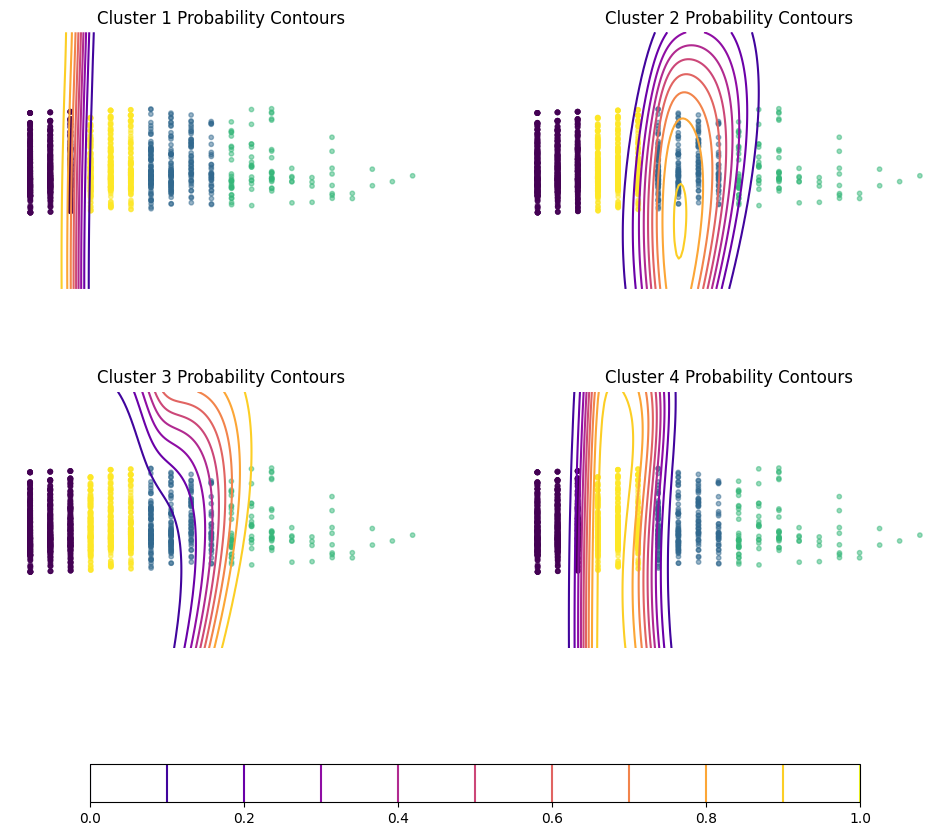

In [18]:
# 7. 시각화 (클러스터별 확률 컨투어)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i in range(4):
    ax = axes[i // 2, i % 2]
    Z_i = Z[:, i].reshape(X_grid.shape)

    contour = ax.contour(X_grid, Y_grid, Z_i, levels=10, cmap='plasma')
    ax.set_title(f"Cluster {i+1} Probability Contours")
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10, alpha=0.5)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_axis_off()

plt.subplots_adjust(hspace=0.4)
fig.colorbar(contour, ax=axes, orientation='horizontal', fraction=0.05)
plt.show()

In [19]:
# Probability each data point of being part of a certain cluster
probs = gmm.predict_proba(X_pca)
probs[0]

array([2.71644638e-20, 5.86934686e-01, 4.12984460e-01, 8.08542740e-05])

In [20]:
from sklearn.metrics import silhouette_score, pairwise_distances

# Silhouette Score 계산
labels = gmm.predict(X_pca)
sil_score = silhouette_score(X_pca, labels)
print('Silhouette coefficient of GMM:', sil_score)

# Dunn Index 함수 정의
def dunn_index(X, labels):
    n_clusters = len(np.unique(labels))
    distances = pairwise_distances(X)

    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            inter_dist = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_dist)

    intra_cluster_distances = []
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        intra_dist = np.max(pairwise_distances(cluster_i))
        intra_cluster_distances.append(intra_dist)

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(intra_cluster_distances)

    return min_inter / max_intra

# Dunn Index 계산
dunn = dunn_index(X_pca, labels)
print('Dunn Index of GMM:', dunn)


Silhouette coefficient of GMM: 0.5883039420776744
Dunn Index of GMM: 0.10987542427562176


In [ ]:
df_combined['cluster'] = labels

# CSV로 저장
df_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/final_profiles_with_clusters.csv', index=False)

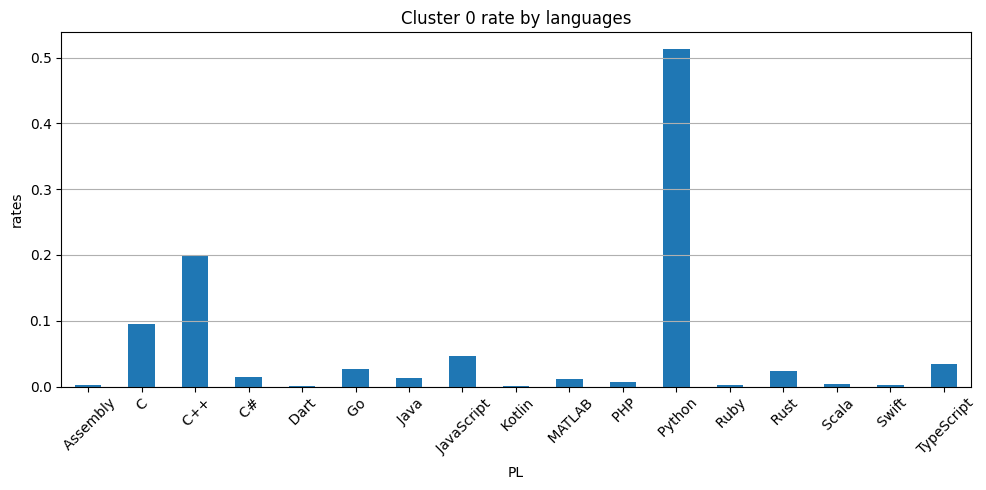

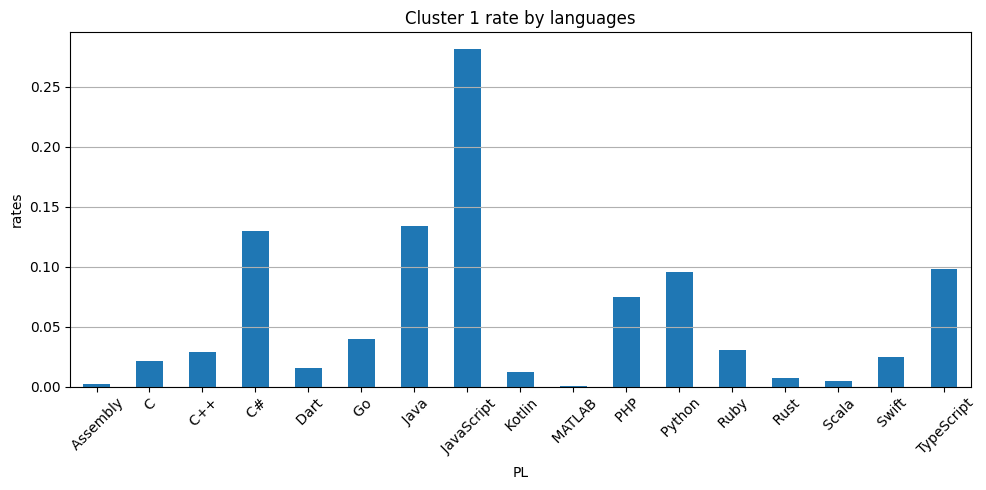

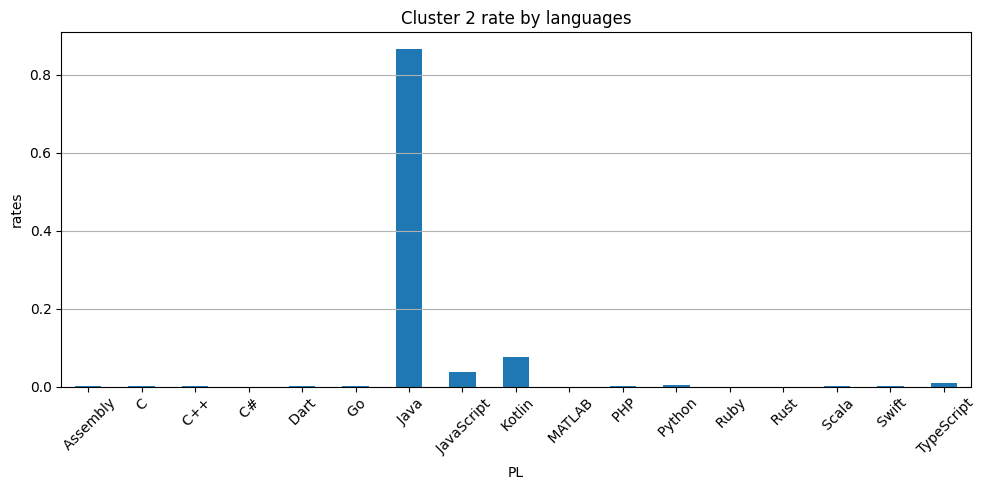

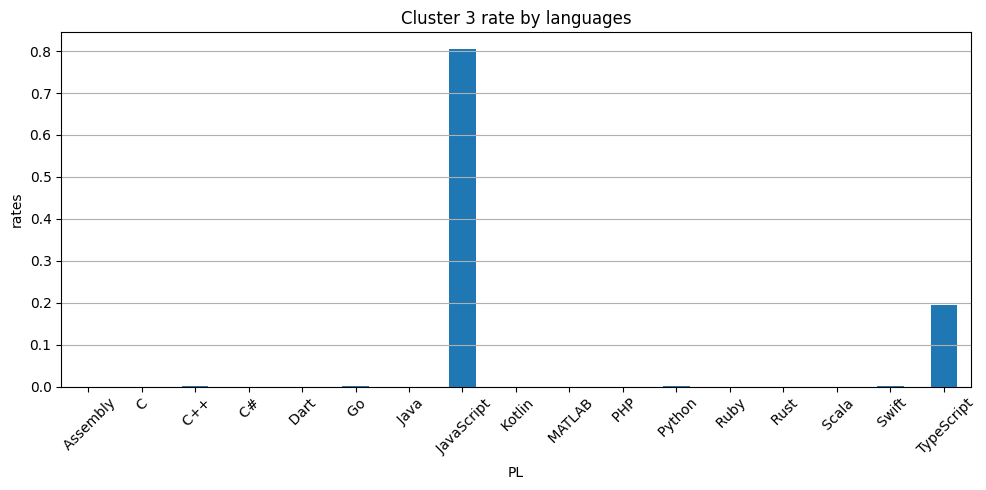

In [ ]:
language_columns = df_combined.columns[1:-1]  # '유저', 'ID', ..., 'cluster' 제외

# 클러스터별 평균 언어 비율 계산
cluster_profiles = df_combined.groupby('cluster')[language_columns].mean()

# 시각화: 각 클러스터의 평균 언어 비율
for cluster_id in cluster_profiles.index:
    plt.figure(figsize=(10, 5))
    cluster_profiles.loc[cluster_id].plot(kind='bar')
    plt.title(f"Cluster {cluster_id} rate by languages")
    plt.ylabel("rates")
    plt.xlabel("PL")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# 클러스터별로 가장 높은 확률을 가진 인덱스 찾기
probs = gmm.predict_proba(X_pca)  # 또는 GMM에 사용한 입력 (X_scaled 등)
# 몇 명 뽑을지 설정
top_n = 5

# 클러스터별 상위 top_n 사용자 ID 출력
for cluster_id in range(gmm.n_components):
    # 해당 클러스터에 대한 소속 확률 벡터
    cluster_probs = probs[:, cluster_id]

    # 확률 내림차순으로 인덱스 정렬
    top_indices = np.argsort(cluster_probs)[::-1][:top_n]

    print(f"\n🔹 Cluster {cluster_id} 상위 {top_n} 대표자:")
    for rank, idx in enumerate(top_indices, 1):
        user_id = df_combined.iloc[idx]['유저 ID']
        prob = cluster_probs[idx]
        print(f"  {rank}. ID: {user_id} (확률: {prob:.4f})")



🔹 Cluster 0 상위 5 대표자:
  1. ID: mxxo (확률: 0.9998)
  2. ID: mxxo (확률: 0.9998)
  3. ID: kali-muon (확률: 0.9998)
  4. ID: kali-muon (확률: 0.9998)
  5. ID: nidhi-desai (확률: 0.9998)

🔹 Cluster 1 상위 5 대표자:
  1. ID: chrisrochford (확률: 1.0000)
  2. ID: chrisrochford (확률: 1.0000)
  3. ID: Ankhana (확률: 1.0000)
  4. ID: Ankhana (확률: 1.0000)
  5. ID: xiaodekaixin (확률: 1.0000)

🔹 Cluster 2 상위 5 대표자:
  1. ID: shivayogih (확률: 0.9996)
  2. ID: mendeleev23 (확률: 0.9996)
  3. ID: shivayogih (확률: 0.9996)
  4. ID: mendeleev23 (확률: 0.9996)
  5. ID: max-zhilin (확률: 0.9996)

🔹 Cluster 3 상위 5 대표자:
  1. ID: katieburak (확률: 0.9997)
  2. ID: AkshantUjjwal (확률: 0.9997)
  3. ID: KaueFernandes01 (확률: 0.9997)
  4. ID: Refagi (확률: 0.9997)
  5. ID: AbhinavaSanthosh (확률: 0.9997)


# 3. Solution: Do not use PCA

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances

# 원본 데이터 사용
X_input = X  # PCA 사용 X

# 2. GMM 학습
gmm_pure = GaussianMixture(n_components=4, random_state=42)
gmm_pure.fit(X)
labels = gmm_pure.predict(X)

# 3. 평가
sil_score_pure = silhouette_score(X, labels)
print("Silhouette score without PCA:", sil_score_pure)
# Dunn Index 함수 정의
def dunn_index(X, labels):
    n_clusters = len(np.unique(labels))
    distances = pairwise_distances(X)

    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            inter_dist = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_dist)

    intra_cluster_distances = []
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        intra_dist = np.max(pairwise_distances(cluster_i))
        intra_cluster_distances.append(intra_dist)

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(intra_cluster_distances)

    return min_inter / max_intra

# Dunn Index 계산
dunn_pure = dunn_index(X, labels)
print('Dunn Index of GMM:', dunn_pure)

Silhouette score without PCA: -0.019065078957585996
Dunn Index of GMM: 0.005248638810827311


In [8]:
probs = gmm_pure.predict_proba(X)
probs[0]

array([7.14480503e-14, 3.09889108e-16, 5.66957556e-10, 9.99999999e-01])

In [ ]:
# 필요시 사용. pca를 이미 실행해버렸다면 사용할 것. 기존 cluster 컬럼 삭제
df.drop('cluster', axis=1, inplace=True)

In [10]:
df['cluster'] = labels

# CSV로 저장
df.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/final_profiles_with_clusters.csv', index=False)

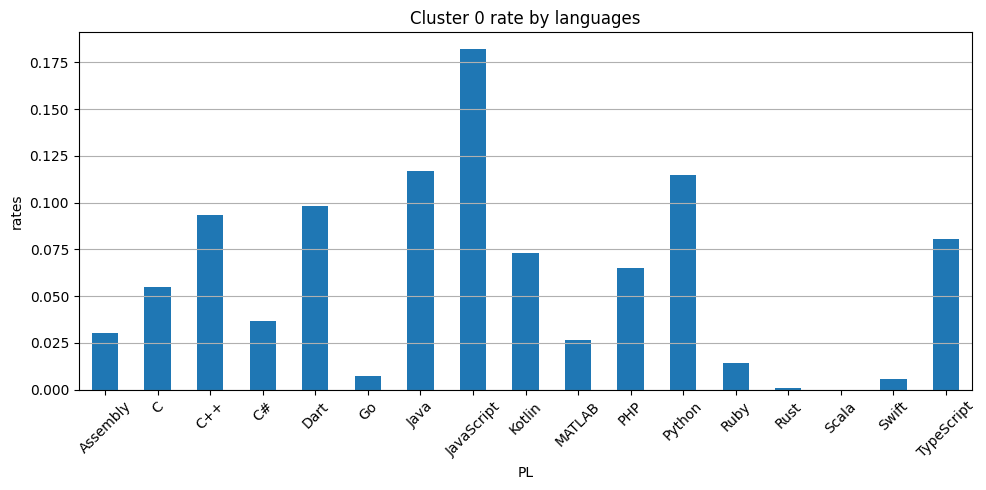

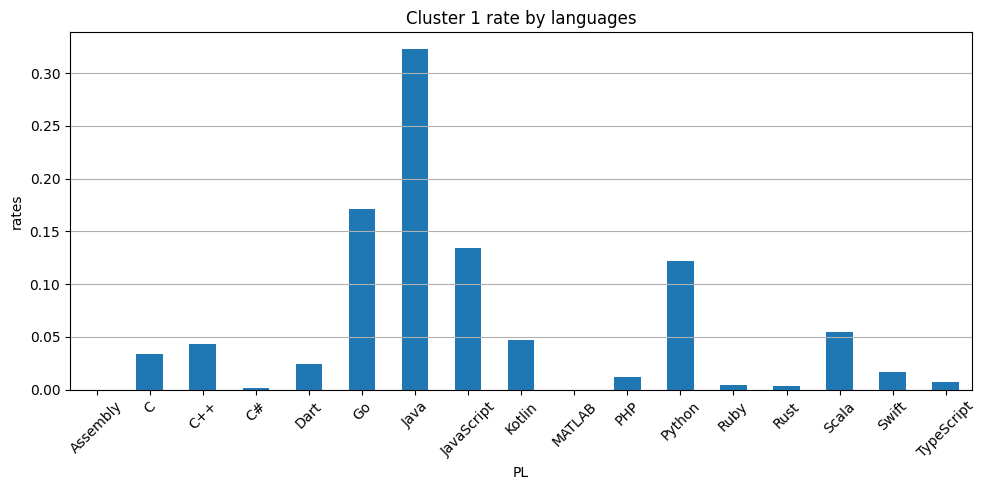

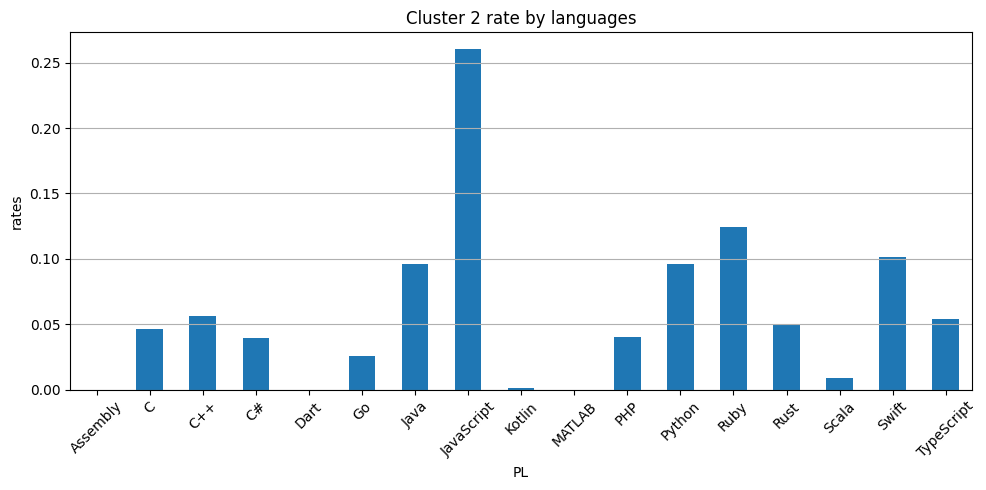

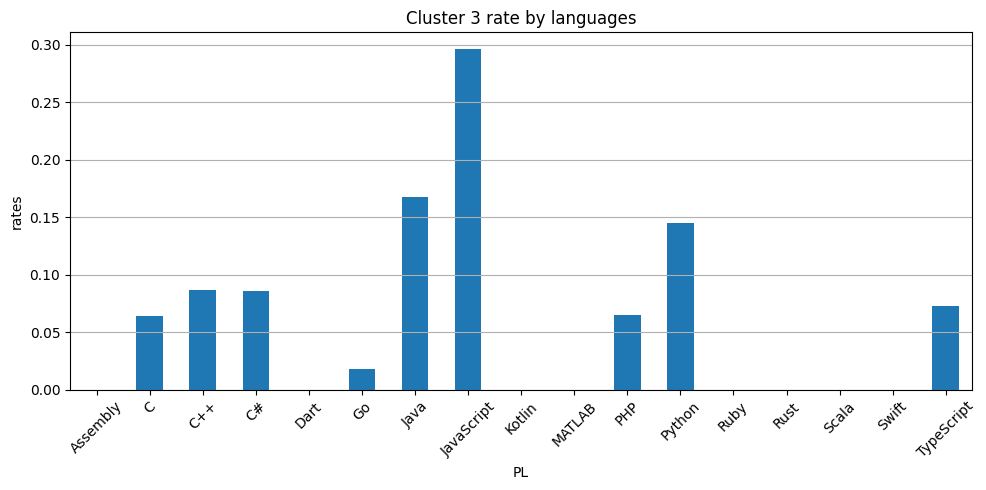

In [11]:
language_columns = df.columns[3:-1]  # '유저', 'ID', ..., 'cluster' 제외

# 클러스터별 평균 언어 비율 계산
cluster_profiles = df.groupby('cluster')[language_columns].mean()

# 시각화: 각 클러스터의 평균 언어 비율
for cluster_id in cluster_profiles.index:
    plt.figure(figsize=(10, 5))
    cluster_profiles.loc[cluster_id].plot(kind='bar')
    plt.title(f"Cluster {cluster_id} rate by languages")
    plt.ylabel("rates")
    plt.xlabel("PL")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [13]:
# 클러스터별로 가장 높은 확률을 가진 인덱스 찾기
probs = gmm_pure.predict_proba(X)  # 또는 GMM에 사용한 입력 (X_scaled 등)
# 몇 명 뽑을지 설정
top_n = 5

# 클러스터별 상위 top_n 사용자 ID 출력
for cluster_id in range(gmm_pure.n_components):
    # 해당 클러스터에 대한 소속 확률 벡터
    cluster_probs = probs[:, cluster_id]

    # 확률 내림차순으로 인덱스 정렬
    top_indices = np.argsort(cluster_probs)[::-1][:top_n]

    print(f"\n🔹 Cluster {cluster_id} 상위 {top_n} 대표자:")
    for rank, idx in enumerate(top_indices, 1):
        username = df.iloc[idx]['username']
        prob = cluster_probs[idx]
        print(f"  {rank}. ID: {username} (확률: {prob:.4f})")


🔹 Cluster 0 상위 5 대표자:
  1. ID: pablophg (확률: 1.0000)
  2. ID: mkjiau (확률: 1.0000)
  3. ID: j4nk3e (확률: 1.0000)
  4. ID: broftkd (확률: 1.0000)
  5. ID: ilent2 (확률: 1.0000)

🔹 Cluster 1 상위 5 대표자:
  1. ID: swdee (확률: 1.0000)
  2. ID: dongjiang1989 (확률: 1.0000)
  3. ID: felipegutierrez (확률: 1.0000)
  4. ID: devagorilla (확률: 1.0000)
  5. ID: bsdnet (확률: 1.0000)

🔹 Cluster 2 상위 5 대표자:
  1. ID: abuecker (확률: 1.0000)
  2. ID: marekstachura (확률: 1.0000)
  3. ID: marcomedina (확률: 1.0000)
  4. ID: stakkato95 (확률: 1.0000)
  5. ID: guzuomuse (확률: 1.0000)

🔹 Cluster 3 상위 5 대표자:
  1. ID: FilixXxMal (확률: 1.0000)
  2. ID: fdecaire (확률: 1.0000)
  3. ID: budul100 (확률: 1.0000)
  4. ID: hunix (확률: 1.0000)
  5. ID: wladmis (확률: 1.0000)


# 4. What if the use of UMAP with 5 dimensions?

In [31]:
import umap
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

In [32]:
# UMAP으로 5차원 축소
reducer = umap.UMAP(n_components=5, random_state=42)
X_umap = reducer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [42]:
# 2. GMM 학습
bic_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_umap)
    bic_scores.append(gmm.bic(X_umap))
# 최소 BIC 값의 클러스터 수 사용
optimal_k = np.argmin(bic_scores) + 2

# 최적 k에 대해 GMM 재학습하고 labels 예측
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
labels = gmm.fit_predict(X_umap)

# 4. Silhouette Score
sil_score = silhouette_score(X_umap, labels)
print("Silhouette score with UMAP:", sil_score)
# Dunn Index 함수 정의
def dunn_index(X, labels):
    n_clusters = len(np.unique(labels))
    distances = pairwise_distances(X)

    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            inter_dist = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_dist)

    intra_cluster_distances = []
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        intra_dist = np.max(pairwise_distances(cluster_i))
        intra_cluster_distances.append(intra_dist)

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(intra_cluster_distances)

    return min_inter / max_intra

# Dunn Index 계산
dunn = dunn_index(X_umap, labels)
print("Dunn Index with UMAP:", dunn)
print(optimal_k)

Silhouette score with UMAP: 0.35568354
Dunn Index with UMAP: 0.00041984764
9


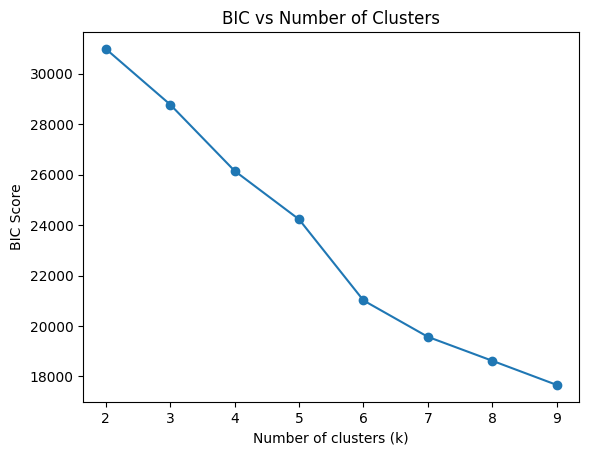

In [41]:
import matplotlib.pyplot as plt

plt.plot(range(2, 10), bic_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("BIC Score")
plt.title("BIC vs Number of Clusters")
plt.show()

In [43]:
probs = gmm.predict_proba(X_umap)
probs[0]

array([2.60437788e-001, 1.58926410e-030, 7.39562210e-001, 6.39926412e-174,
       1.99951314e-009, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [44]:
df = df.drop('cluster', axis=1)

In [45]:
df['cluster'] = labels

# CSV로 저장
df.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/final_profiles_with_clusters.csv', index=False)

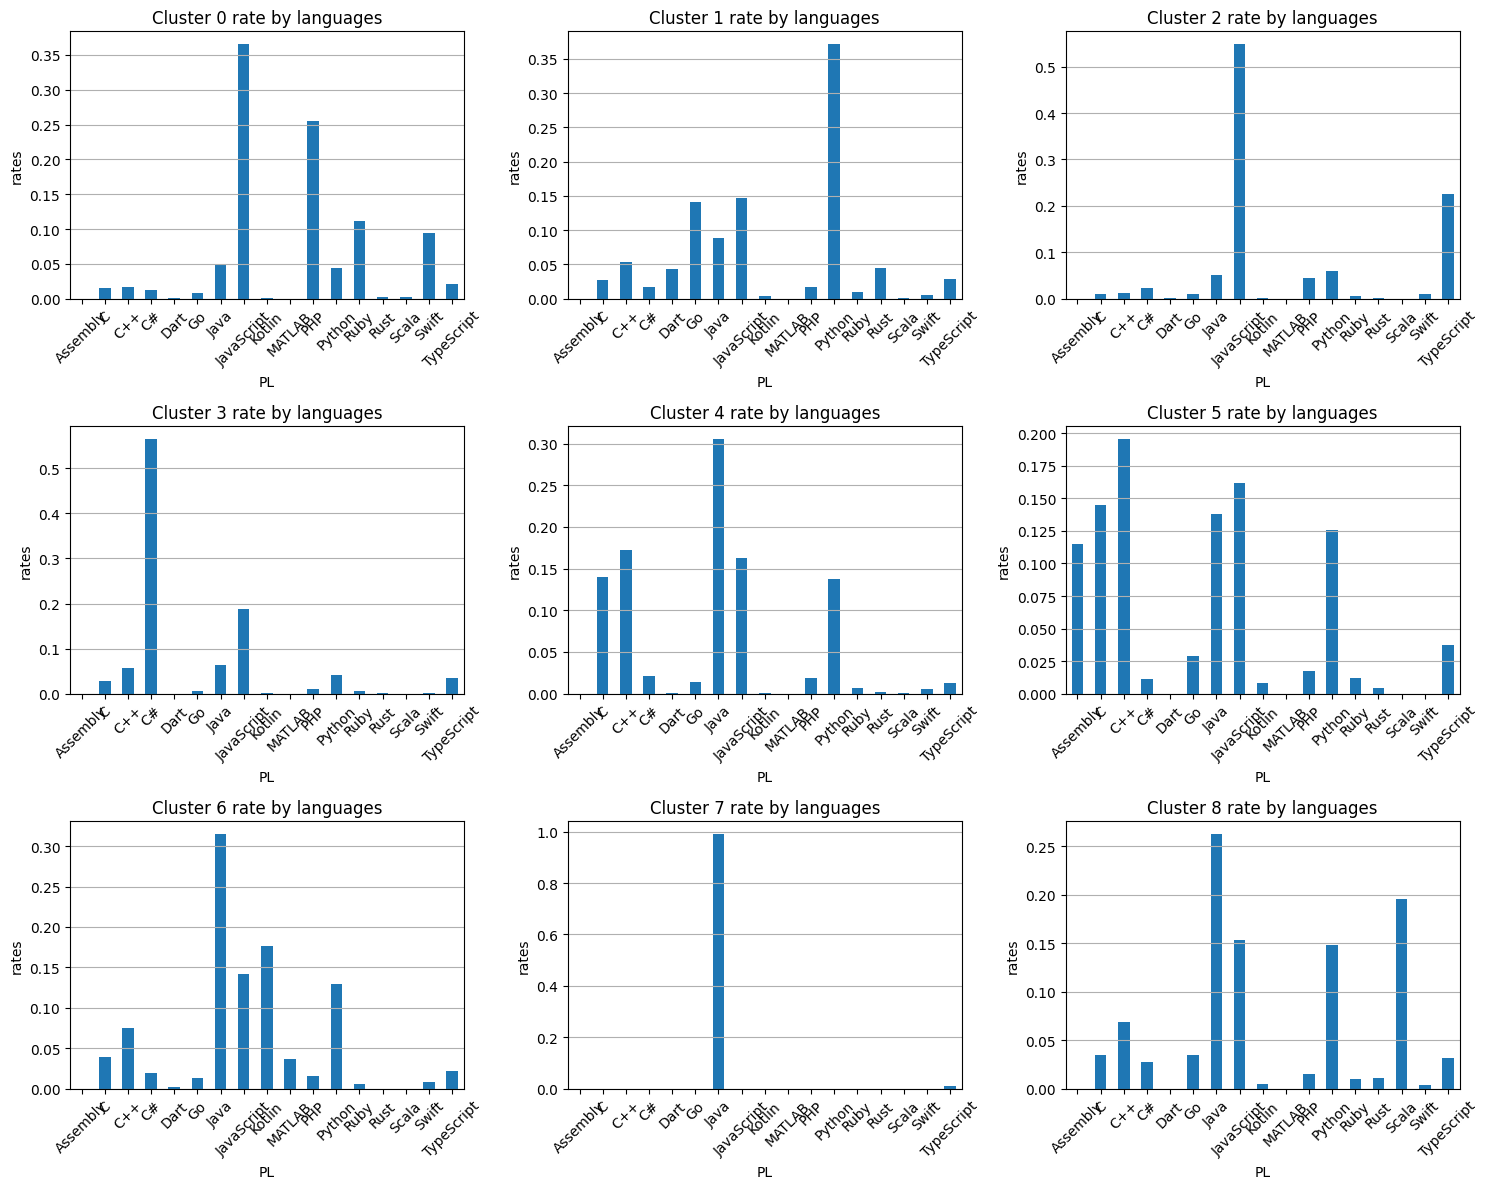

In [47]:
language_columns = df.columns[3:-1]  # '유저', 'ID', ..., 'cluster' 제외

# 클러스터별 평균 언어 비율 계산
cluster_profiles = df.groupby('cluster')[language_columns].mean()

# 시각화: 하나의 그림에 2x2 서브플롯으로 표시
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) # 그림 크기 조절
axes = axes.flatten() # 2x2 배열을 1차원 배열로 만듬 (인덱싱을 쉽게 하기 위함)

for i, cluster_id in enumerate(cluster_profiles.index):
    ax = axes[i]
    cluster_profiles.loc[cluster_id].plot(kind='bar', ax=ax)
    ax.set_title(f"Cluster {cluster_id} rate by languages")
    ax.set_ylabel("rates")
    ax.set_xlabel("PL")
    ax.tick_params(axis='x', rotation=45) # x축 레이블 회전
    ax.grid(axis='y')

plt.tight_layout() # 서브플롯 간의 간격 자동 조절
plt.show()

In [48]:
# 클러스터별로 가장 높은 확률을 가진 인덱스 찾기
probs = gmm.predict_proba(X_umap)  # 또는 GMM에 사용한 입력 (X_scaled 등)
# 몇 명 뽑을지 설정
top_n = 5

# 클러스터별 상위 top_n 사용자 ID 출력
for cluster_id in range(gmm.n_components):
    # 해당 클러스터에 대한 소속 확률 벡터
    cluster_probs = probs[:, cluster_id]

    # 확률 내림차순으로 인덱스 정렬
    top_indices = np.argsort(cluster_probs)[::-1][:top_n]

    print(f"\n🔹 Cluster {cluster_id} 상위 {top_n} 대표자:")
    for rank, idx in enumerate(top_indices, 1):
        username = df.iloc[idx]['username']
        prob = cluster_probs[idx]
        print(f"  {rank}. ID: {username} (확률: {prob:.4f})")


🔹 Cluster 0 상위 5 대표자:
  1. ID: pleonard212 (확률: 1.0000)
  2. ID: lkaina (확률: 1.0000)
  3. ID: Mojgan-Jelodar (확률: 1.0000)
  4. ID: dfvg (확률: 1.0000)
  5. ID: faceleg (확률: 1.0000)

🔹 Cluster 1 상위 5 대표자:
  1. ID: matthewtsmith (확률: 1.0000)
  2. ID: azeymur (확률: 1.0000)
  3. ID: yoshihitoh (확률: 1.0000)
  4. ID: gitbufenshuo (확률: 1.0000)
  5. ID: guzuomuse (확률: 1.0000)

🔹 Cluster 2 상위 5 대표자:
  1. ID: arielbouskila (확률: 1.0000)
  2. ID: shaunburdick (확률: 1.0000)
  3. ID: SparkFountain (확률: 1.0000)
  4. ID: inidaname (확률: 1.0000)
  5. ID: kumarryogeshh (확률: 1.0000)

🔹 Cluster 3 상위 5 대표자:
  1. ID: pianomanjh (확률: 1.0000)
  2. ID: DaveCS1 (확률: 1.0000)
  3. ID: brandonbisel (확률: 1.0000)
  4. ID: pjcollins (확률: 1.0000)
  5. ID: makcakaya (확률: 1.0000)

🔹 Cluster 4 상위 5 대표자:
  1. ID: gemarcano (확률: 1.0000)
  2. ID: xiaoyangxie (확률: 1.0000)
  3. ID: Al-th (확률: 1.0000)
  4. ID: zenglongtest (확률: 1.0000)
  5. ID: taiqiang (확률: 1.0000)

🔹 Cluster 5 상위 5 대표자:
  1. ID: Siyet (확률: 1.0000)
  2. ID: fly13